In [104]:
import numpy as np # always need it
import scipy as sp # often use it
import pylab as pl # do the plots
import seaborn as sns # for pretty plots
import matplotlib.pyplot as plt # for pretty plots
from mpl_toolkits.mplot3d import Axes3D

import ot # ot 

In [64]:
def Convolution_Wasserstein(a, b, C, l):
    u = np.ones(len(a))
    K = np.exp(-C/l)
    for i in range(len(a)):
        v = b / (K.T @ u)
        u = a / (K @ v)
    T = np.diag(u) @ K @ np.diag(v)
    return T

In [65]:
def Wasserstein_barycentre(mu_i, alpha, Ht, a, ent_sharp = False, N = 2):
    k = len(mu_i[0])
    d = np.zeros((2, k))
    v = np.ones((2,k))
    w = np.ones((2,k))
    for j in range(N):
        mu = np.ones(k)
        for i in range(2):
            w[i] = mu_i[i]/(Ht @ (a*v[i]))
            d[i] = v[i]*(Ht@(a*w[i]))
            mu = mu*d[i]**alpha[i]

        #entropic sharpening, optional
        if (ent_sharp):
            H_0 = H0(mu_i, a)
            mu = entropic_sharpening(mu, H_0, a)

        for i in range(2):
            v[i] = v[i]*mu/d[i]

    return mu




In [66]:
def entropic_sharpening(mu, H0, a):
    beta = 1
    if(H(mu, a) + np.transpose(a)*mu > H0 + 1 ):
        beta = sp.optimize.root(np.transpose(a)*mu**beta + H(mu**beta, a) - (1 + H0), beta > 0)
    return mu**beta

In [67]:
def H(mu, a):
    sum = 0
    for i in range(len(mu)):
        sum -= a[i] * mu[i] * np.log(mu[i])
    return sum

In [68]:
def H0(mu_i,a):
    for i in range(len(mu_i)):
        h = H(mu_i[i],a)
        if(h > H0):
            H0 = h 
    return h

In [69]:
def Wasserstein_propagation(V, E, V0, mu_V0, Ht, a, alpha, N = 2):
    m = len(V)
    ne = len(E)
    m0,k0 = np.shape(mu_V0)
    v = np.ones((ne,k0))
    w = np.ones((k,k0))
    mu = np.ones((m,k0))
    d = np.zeros((ne,k0))
    for j in range(N):
        for i in range(m):
            if (V[i] in V0):
                mu[i] = V0(V0.index(V[i]))
                for l in range(k): #on parcourt les aretes
                    e = E[l]
                    if e[1] == V[i] :
                        w[l] = mu / Ht @ (a * v[l])
                    if e[0] == V[i] :
                        v[l] = mu / Ht @ (a * w[l])
            else:
                omega = 0
                for l in range(k):
                    e = E[l]
                    if(e[1]==V[i] or e[0]==V[i]):
                        omega += alpha[l]
                for l in range(k): #on parcourt les aretes
                    e = E[l]
                    if e[1] == V[i] :
                        d[l] = w[l] * Ht @ (a * v[l])
                    if e[0] == V[i] :
                        d[l] = v[l] * Ht @ (a * w[l])
                    mu[i] = mu[i] * d[l]**(alpha[l]/omega)
                for l in range(k): #on parcourt les aretes
                    e = E[l]
                    if e[1] == V[i] :
                        w[l] = w[l] * mu[i]/d[l]
                    if e[0] == V[i] :
                        v[l] = v[l] * mu[i]/d[l]
    return mu

In [106]:
class point:
    def __init__(self, x, y, z, w):
        self.x = x
        self.y = y
        self.z = z
        self.weight = w

mesh1 = np.zeros((1000), point)
alpha1 = np.zeros(1000)

for i in range(10):
    for j in range(10):
        for k in range(10):
            mesh1[i*100+j*10+k] = point(i,j,k,1)
            alpha1[i*100+j*10+k] = 1

mesh2 = np.zeros(1000, point)
alpha2 = np.zeros(1000)
r = 5

for i in range(10):
    for j in range(10):
        for k in range(10):
            if np.linalg.norm([i - 5, j - 5.,k - 5.]) < r :
                mesh2[i*100+j*10+k] = point(i,j,k,1)
                alpha2[i*100+j*10+k] = 1
            else : 
                mesh2[i*100+j*10+k] = point(i,j,k,0)
                alpha2[i*100+j*10+k] = 0.01

alpha1 = alpha1/np.linalg.norm(alpha1)
alpha2 = alpha2/np.linalg.norm(alpha2)
print(alpha2)

[0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405
 0.00045405 0.00045405 0.00045405 0.00045405 0.00045405 0.0004

In [71]:
def kernel(n1, n2, gamma): 
    a = np.zeros((n1, n2))
    min = np.infty
    for i1 in range(n1):
        for i2 in range(n2):
            if min > -np.linalg.norm([mesh1[i1].x - mesh2[i2].x, mesh1[i1].y - mesh2[i2].y, mesh1[i1].z - mesh2[i2].z])**2 / gamma:
                min = -np.linalg.norm([mesh1[i1].x - mesh2[i2].x, mesh1[i1].y - mesh2[i2].y, mesh1[i1].z - mesh2[i2].z])**2 / gamma
            a[i1,i2] = np.exp(-np.linalg.norm([mesh1[i1].x/10 - mesh2[i2].x/10, mesh1[i1].y/10 - mesh2[i2].y/10, mesh1[i1].z/10 - mesh2[i2].z/10])**2 / gamma)
            # if a[i1,i2] == 0 : 
                # print(-np.linalg.norm([mesh1[i1].x - mesh2[i2].x, mesh1[i1].y - mesh2[i2].y, mesh1[i1].z - mesh2[i2].z])**2 / gamma)
                # return a
    print(min)
    return a

In [72]:
n1 = 1000
n2 = 1000
gamma = 0.1
Ht = kernel(n1, n2, gamma)
a = 1/(n1)

-2430.0


In [73]:
print(Ht[Ht==0])

[]


In [79]:
mu = Wasserstein_barycentre((alpha1, alpha2), (0.5, 0.5), Ht, a, N=2)


In [80]:
print(mu)

[0.00747796 0.00967299 0.01139611 0.01252768 0.01314441 0.01335628
 0.01314085 0.01232426 0.01074719 0.00848749 0.00967299 0.01261545
 0.01496243 0.01652608 0.01738795 0.01768861 0.01740197 0.01630463
 0.01419506 0.01118718 0.01139611 0.01496243 0.0178376  0.01976995
 0.02084191 0.02122037 0.0208787  0.01955442 0.01701155 0.01339314
 0.01252768 0.01652608 0.01976995 0.02196004 0.02317872 0.02361257
 0.02323652 0.02176215 0.01892905 0.0148985  0.01314441 0.01738795
 0.02084191 0.02317872 0.02448061 0.0249461  0.02455196 0.02299553
 0.02000232 0.01574292 0.01335628 0.01768861 0.02122037 0.02361257
 0.0249461  0.02542307 0.0250209  0.02343242 0.02037921 0.01603652
 0.01314085 0.01740197 0.0208787  0.02323652 0.02455196 0.0250209
 0.02461981 0.02304753 0.02003366 0.01575496 0.01232426 0.01630463
 0.01955442 0.02176215 0.02299553 0.02343242 0.02304753 0.02156018
 0.01872296 0.01470853 0.01074719 0.01419506 0.01701155 0.01892905
 0.02000232 0.02037921 0.02003366 0.01872296 0.01623876 0.01273

In [96]:
def mu_coords(mu):
    n = len(mu)
    m = int(n**(1/3))
    Coord = np.zeros(shape = (m,m,m))
    for i in range(m):
        for j in range(m):
            for k in range(m):
                Coord[i,j,k] = mu[i*100 + j*10 + k]
    return Coord
        

In [97]:
print(mu_coords(mu))

[[[0.00747796 0.00967299 0.01139611 0.01252768 0.01314441 0.01335628
   0.01314085 0.01232426 0.01074719]
  [0.00967299 0.01261545 0.01496243 0.01652608 0.01738795 0.01768861
   0.01740197 0.01630463 0.01419506]
  [0.01139611 0.01496243 0.0178376  0.01976995 0.02084191 0.02122037
   0.0208787  0.01955442 0.01701155]
  [0.01252768 0.01652608 0.01976995 0.02196004 0.02317872 0.02361257
   0.02323652 0.02176215 0.01892905]
  [0.01314441 0.01738795 0.02084191 0.02317872 0.02448061 0.0249461
   0.02455196 0.02299553 0.02000232]
  [0.01335628 0.01768861 0.02122037 0.02361257 0.0249461  0.02542307
   0.0250209  0.02343242 0.02037921]
  [0.01314085 0.01740197 0.0208787  0.02323652 0.02455196 0.0250209
   0.02461981 0.02304753 0.02003366]
  [0.01232426 0.01630463 0.01955442 0.02176215 0.02299553 0.02343242
   0.02304753 0.02156018 0.01872296]
  [0.01074719 0.01419506 0.01701155 0.01892905 0.02000232 0.02037921
   0.02003366 0.01872296 0.01623876]]

 [[0.00967299 0.01261545 0.01496243 0.01652608

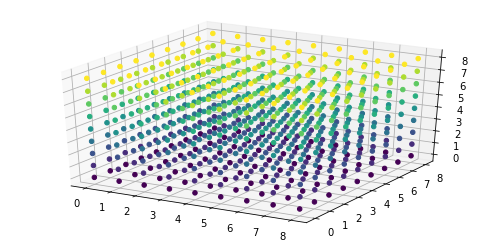

In [108]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")
z, x, y = mu_coords(alpha1).nonzero()
ax.scatter(x, y, z, c=z, alpha=1)
plt.show()